In [1]:
import cfgrib
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("..")

from baselines.data_processor import DataProcessor
from baselines.cnn.cnn import UNet

c:\Users\iwama\Desktop\Maciej\Eng\meteoapp-data\venv\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022-2div.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 3
fh = 3

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=False)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [5]:
X_train.shape, y_train.shape

((1141, 32, 48, 3, 6), (1141, 32, 48, 3, 6))

In [6]:
X_train, X_test, y_train, y_test = np.float32(X_train), np.float32(X_test), np.float32(y_train), np.float32(y_test)
X_train = X_train.reshape(X_train.shape[0], 32, 48, s*len(feature_list))
y_train = y_train.reshape(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 32, 48, s*len(feature_list))
y_test = y_test.reshape(X_test.shape)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1141, 32, 48, 18), (1141, 32, 48, 18), (286, 32, 48, 18), (286, 32, 48, 18))

In [8]:
X_train = X_train.transpose(0, 3, 1, 2)
y_train = y_train.transpose(0, 3, 1, 2)
X_test = X_test.transpose(0, 3, 1, 2)
y_test = y_test.transpose(0, 3, 1, 2)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1141, 18, 32, 48), (1141, 18, 32, 48), (286, 18, 32, 48), (286, 18, 32, 48))

In [10]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print("Device:", device)

Device: cuda


In [11]:
model = UNet(features=18).to(device)

In [12]:
training_loader = torch.utils.data.DataLoader([X_train, y_train], batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader([X_test, y_test], batch_size=4, shuffle=False)

In [13]:
loss_mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
def train_epoch(epoch_index):
    last_loss = 0
    val_loss = 0
    model.train()

    for (inputs, labels) in training_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = loss_mse(outputs, labels)
        loss.backward()

        last_loss += loss

        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += loss_mse(outputs, labels)


    return last_loss, val_loss

In [15]:
for epoch in range(5):
    print("EPOCH", epoch)
    train_loss, val_loss = train_epoch(epoch)
    print("Train loss:", train_loss)
    print("Val loss", val_loss)
    print("====================")

EPOCH 0
Train loss: tensor(164796.6094, device='cuda:0', grad_fn=<AddBackward0>)
Val loss tensor(163866.3125, device='cuda:0')
EPOCH 1
Train loss: tensor(163992.7500, device='cuda:0', grad_fn=<AddBackward0>)
Val loss tensor(163529.8281, device='cuda:0')
EPOCH 2
Train loss: tensor(163652.3438, device='cuda:0', grad_fn=<AddBackward0>)
Val loss tensor(163120.8906, device='cuda:0')
EPOCH 3
Train loss: tensor(163238.2500, device='cuda:0', grad_fn=<AddBackward0>)
Val loss tensor(162627.6250, device='cuda:0')
EPOCH 4
Train loss: tensor(162740.1406, device='cuda:0', grad_fn=<AddBackward0>)
Val loss tensor(161987.6875, device='cuda:0')


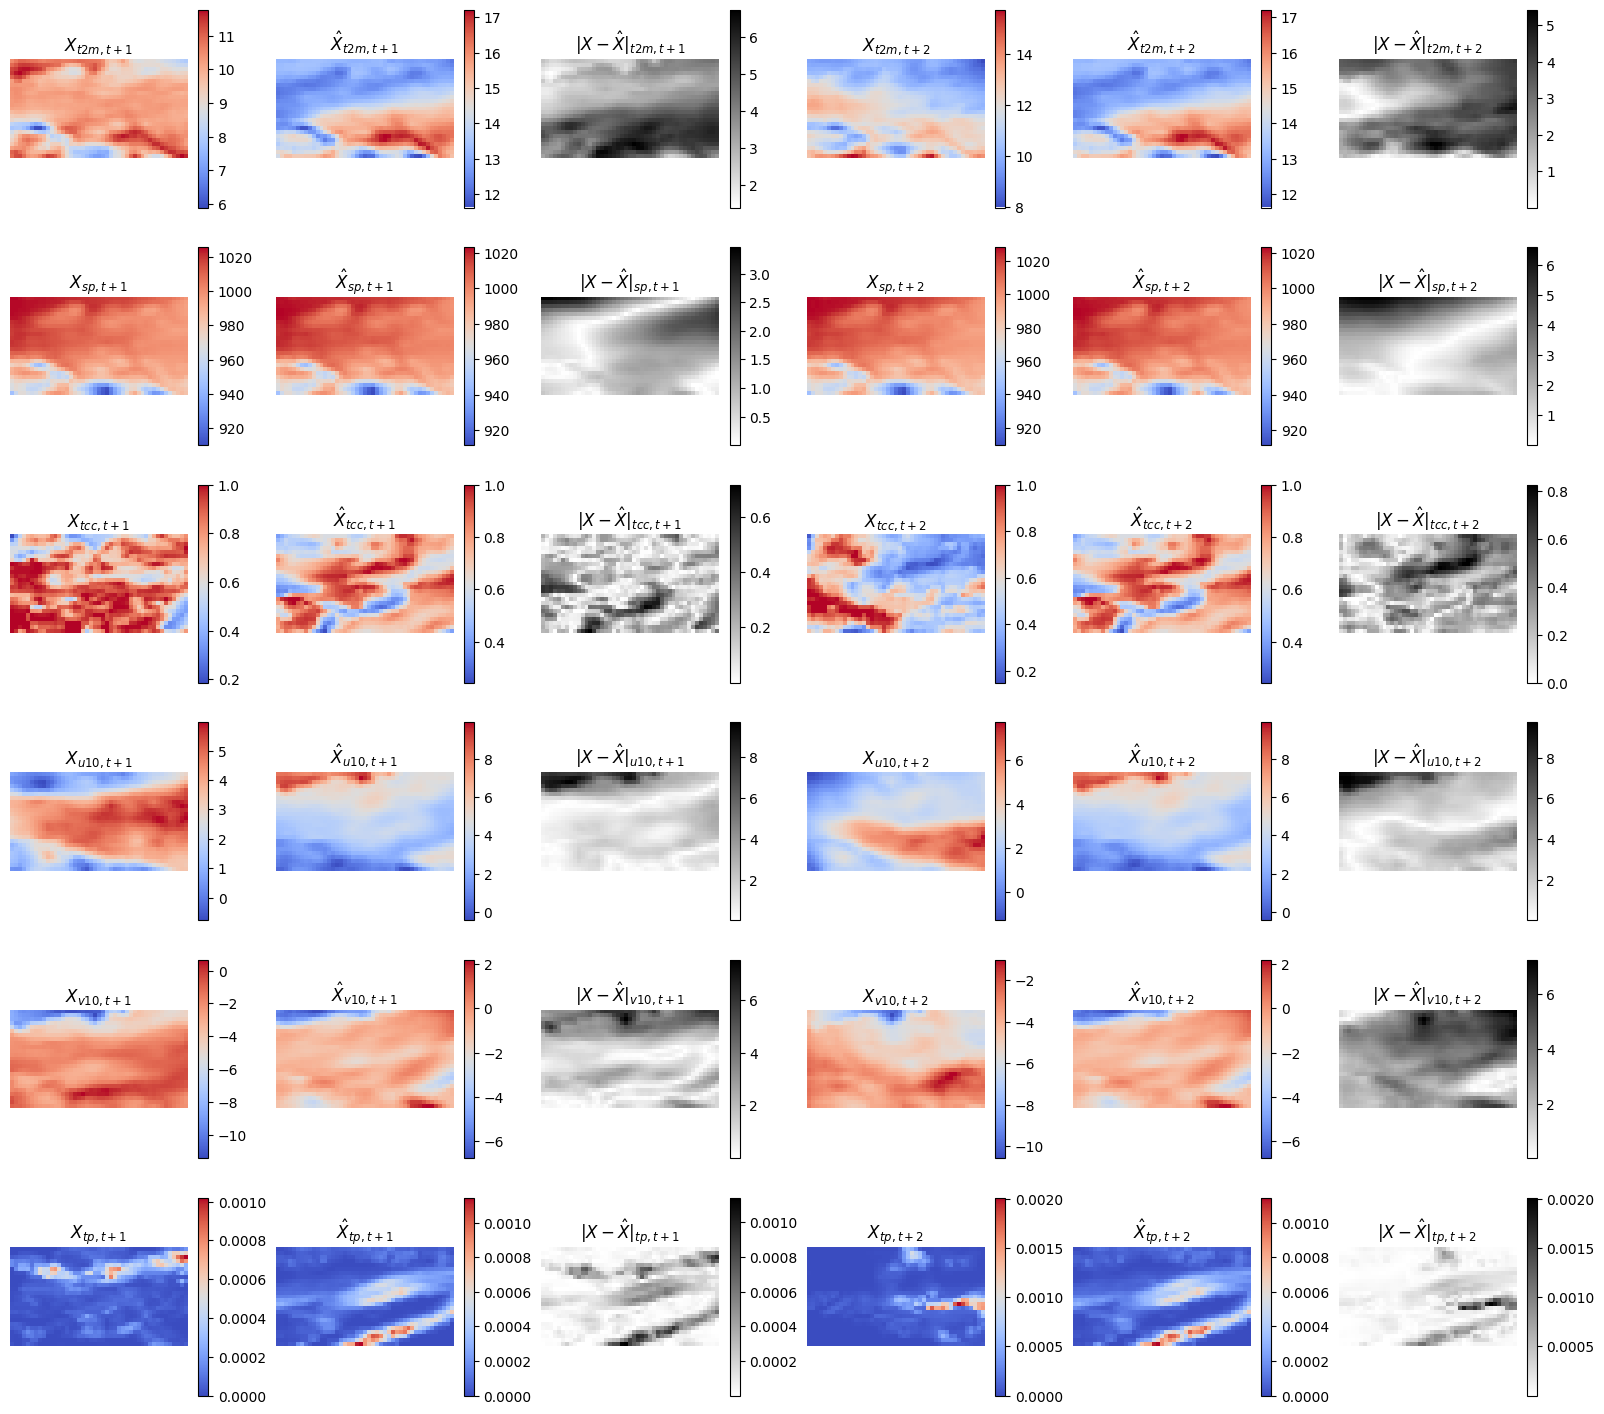

Evaluation metrics for entire test set:
t2m => RMSE: 2.535; SE: 0.00722035292861406
sp => RMSE: 2.996; SE: 0.026186777730342913
tcc => RMSE: 0.282; SE: 0.00034068190903559453
u10 => RMSE: 1.9; SE: 0.003557221413840321
v10 => RMSE: 1.608; SE: 0.002911139152650286
tp => RMSE: 0.0; SE: 2.454296631825405e-07



 2679.79207611084 [s]


In [10]:
from time import time 
start = time()

# print(smoothing.upper(), "@", alpha)
predictor = SmoothingPredictor(X.shape, fh, feature_list, smoothing)
# predictor.train(X_train, y_train)
_ = predictor.predict_and_evaluate(X_test, y_test, max_samples=1)
print("\n======================================\n")

stop = time()
print('\n', stop-start, '[s]')

In [11]:
"""
TEST SET RESULTS FOR DIFFERENT IMPLEMENTATIONS:
a) no training, just 'estimated' init_method (heuristic does not work - min. 10 observations):
SIMPLE:
t2m => RMSE: 3.966; SE: 0.014918221828480993
sp => RMSE: 2.486; SE: 0.07342948176959976
tcc => RMSE: 0.333; SE: 0.0011988784087137597
u10 => RMSE: 2.022; SE: 0.008577662189566968
v10 => RMSE: 1.866; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-0
    time: ~11 minutes (30 examples => ~20s per example)
HOLT:
t2m => RMSE: 6.814; SE: 0.014918221828480993
sp => RMSE: 2.461; SE: 0.07342948176959976
tcc => RMSE: 0.521; SE: 0.0011988784087137597
u10 => RMSE: 2.67; SE: 0.008577662189566968
v10 => RMSE: 2.391; SE: 0.00904395633958023
tp => RMSE: 0.001; SE: 9.430597444098186e-07
    time ~57 minutes (30 examples => ~2 minutes per example) TOO SLOW!
=============================
b) All in one (not pixel by pixel):
SIMPLE
t2m => RMSE: 4.446; SE: 0.014918221828480993
sp => RMSE: 22.368; SE: 0.07342948176959976
tcc => RMSE: 0.394; SE: 0.0011988784087137597
u10 => RMSE: 3.239; SE: 0.008577662189566968
v10 => RMSE: 3.142; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07
HOLT:
t2m => RMSE: 6.666; SE: 0.014918221828480993
sp => RMSE: 28.726; SE: 0.07342948176959976
tcc => RMSE: 7.09; SE: 0.0011988784087137597
u10 => RMSE: 253.311; SE: 0.008577662189566968
v10 => RMSE: 115.572; SE: 0.00904395633958023
tp => RMSE: 0.006; SE: 9.430597444098186e-07
    time: 15s
HOLT_WINTERS:
t2m => RMSE: 5.381; SE: 0.014918221828480993
sp => RMSE: 22.364; SE: 0.07342948176959976
tcc => RMSE: 0.418; SE: 0.0011988784087137597
u10 => RMSE: 3.42; SE: 0.008577662189566968
v10 => RMSE: 3.009; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

W SKRÓCIE - trzeba zrobić dla każdego piksela osobno, jest od połowy do znacznie lepiej
"""
0

0

In [12]:
'''
SIMPLE @ 0.05
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 4.055; SE: 0.014918221828480993
sp => RMSE: 4.46; SE: 0.07342948176959976
tcc => RMSE: 0.385; SE: 0.0011988784087137597
u10 => RMSE: 2.824; SE: 0.008577662189566968
v10 => RMSE: 2.838; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.1
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.904; SE: 0.014918221828480993
sp => RMSE: 4.281; SE: 0.07342948176959976
tcc => RMSE: 0.37; SE: 0.0011988784087137597
u10 => RMSE: 2.711; SE: 0.008577662189566968
v10 => RMSE: 2.717; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.2
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.687; SE: 0.014918221828480993
sp => RMSE: 3.95; SE: 0.07342948176959976
tcc => RMSE: 0.345; SE: 0.0011988784087137597
u10 => RMSE: 2.512; SE: 0.008577662189566968
v10 => RMSE: 2.5; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.3
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.572; SE: 0.014918221828480993
sp => RMSE: 3.653; SE: 0.07342948176959976
tcc => RMSE: 0.329; SE: 0.0011988784087137597
u10 => RMSE: 2.348; SE: 0.008577662189566968
v10 => RMSE: 2.318; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.5
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.57; SE: 0.014918221828480993
sp => RMSE: 3.159; SE: 0.07342948176959976
tcc => RMSE: 0.315; SE: 0.0011988784087137597
u10 => RMSE: 2.113; SE: 0.008577662189566968
v10 => RMSE: 2.045; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.6
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.64; SE: 0.014918221828480993
sp => RMSE: 2.958; SE: 0.07342948176959976
tcc => RMSE: 0.316; SE: 0.0011988784087137597
u10 => RMSE: 2.036; SE: 0.008577662189566968
v10 => RMSE: 1.949; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================

SIMPLE @ 0.8
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.838; SE: 0.014918221828480993
sp => RMSE: 2.637; SE: 0.07342948176959976
tcc => RMSE: 0.326; SE: 0.0011988784087137597
u10 => RMSE: 1.94; SE: 0.008577662189566968
v10 => RMSE: 1.823; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07

======================================
'''
0

0

In [ ]:
'''
temp = 0.3-0.5
tcc = 0.6
sp, wiatr = 0.8
RESULTS:
t2m => RMSE: 3.54; SE: 0.014918221828480993
sp => RMSE: 2.637; SE: 0.07342948176959976
tcc => RMSE: 0.316; SE: 0.0011988784087137597
u10 => RMSE: 1.94; SE: 0.008577662189566968
v10 => RMSE: 1.823; SE: 0.00904395633958023
tp => RMSE: 0.0; SE: 9.430597444098186e-07
    time: 250 s

=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 2.535; SE: 0.00722035292861406
sp => RMSE: 2.996; SE: 0.026186777730342913
tcc => RMSE: 0.282; SE: 0.00034068190903559453
u10 => RMSE: 1.9; SE: 0.003557221413840321
v10 => RMSE: 1.608; SE: 0.002911139152650286
tp => RMSE: 0.0; SE: 2.454296631825405e-07

======================================
Total time taken:
 2679.79207611084 [s] <= 286 examples (45 minutes)
'''